In [1]:
from pathlib import Path
import pandas as pd

In [2]:
# Obtener todos los compact datasets
COMPACT_DIR = Path("D:/2025/UVG/Tesis/repos/backend/features_ready_without_idle_rows/")
feature_engineered_datasets = list(COMPACT_DIR.glob("*.parquet"))
feature_engineered_datasets_names = [f.stem for f in feature_engineered_datasets]

# Leer los datasets compactos
feature_engineered_dfs = {name: pd.read_parquet(COMPACT_DIR / f"{name}.parquet") for name in feature_engineered_datasets_names}

# Agrupar los datasets en un solo dataframe
all_feature_engineered_df = pd.concat(feature_engineered_dfs.values(), ignore_index=True)

In [3]:
# Mostrar las columnas del dataframe combinado
print(all_feature_engineered_df.columns)

Index(['LINEA', 'DIR', 'proxima_est_teorica', 'DIR_init', 'Fecha', 'Placa',
       'trip_id', 'block_id', 'dist_a_prox_m', 'dist_estacion_m', 'vel_mps',
       'Altitud (m)', 's_m', 'dist_m', 'time_diff', 'dwell_same_xy_s',
       'is_no_progress', 'progress_event', 'ETA_proxima_est_s', 'hour', 'dow',
       'is_weekend', 'is_peak'],
      dtype='object')


In [4]:
# Matriz de correlación entre las características numéricas
float_cols = [
    "dist_a_prox_m","dist_estacion_m","vel_mps","Altitud (m)","s_m","dist_m",
    "time_diff","dwell_same_xy_s","ETA_proxima_est_s"
]

correlation_matrix = all_feature_engineered_df[float_cols].corr()

In [5]:
correlation_matrix

,dist_a_prox_m,dist_estacion_m,vel_mps,Altitud (m),s_m,dist_m,time_diff,dwell_same_xy_s,ETA_proxima_est_s
dist_a_prox_m,1.000000,0.370391,-0.019185,-0.345231,-0.297483,0.045883,-0.005519,0.063805,0.420042
dist_estacion_m,0.370391,1.000000,0.371601,-0.220206,0.009419,0.085535,-0.004083,-0.000679,0.119833
vel_mps,-0.019185,0.371601,1.000000,0.004331,0.210270,0.013869,-0.003964,-0.059013,-0.176811
Altitud (m),-0.345231,-0.220206,0.004331,1.000000,0.132321,-0.075616,0.000415,-0.036563,-0.156068
s_m,-0.297483,0.009419,0.210270,0.132321,1.000000,-0.019360,0.002711,-0.036988,-0.173135
dist_m,0.045883,0.085535,0.013869,-0.075616,-0.019360,1.000000,0.001483,0.017160,0.250503
time_diff,-0.005519,-0.004083,-0.003964,0.000415,0.002711,0.001483,1.000000,-0.000146,0.000519
dwell_same_xy_s,0.063805,-0.000679,-0.059013,-0.036563,-0.036988,0.017160,-0.000146,1.000000,0.081627
ETA_proxima_est_s,0.420042,0.119833,-0.176811,-0.156068,-0.173135,0.250503,0.000519,0.081627,1.000000


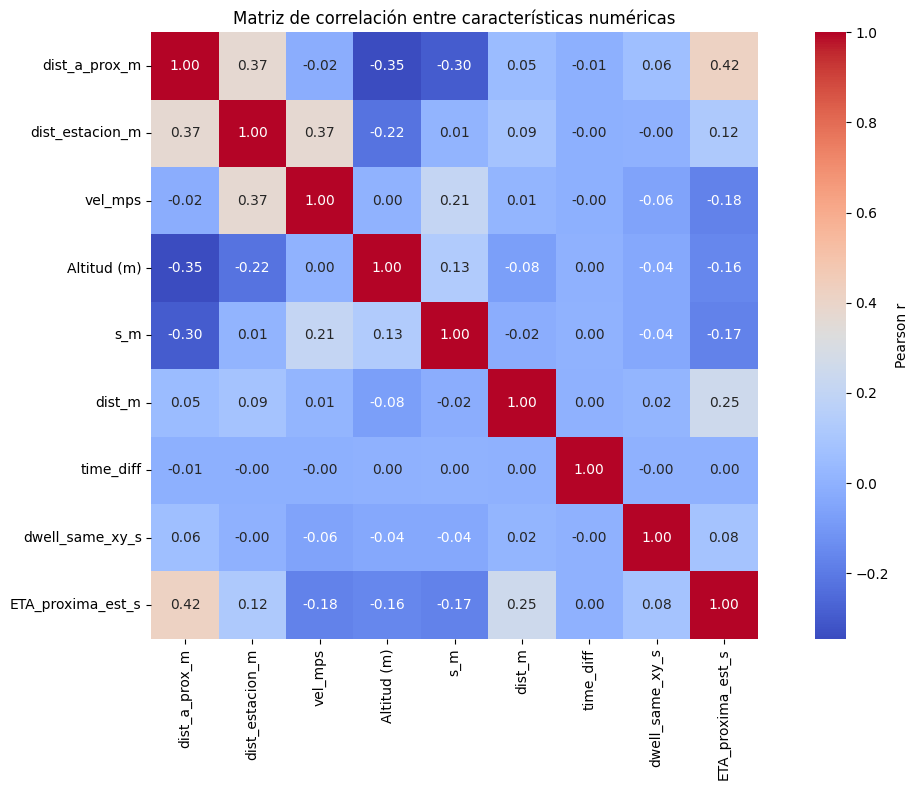

In [7]:
# 4) Visualizar y dejar claro dónde hay NaN
import seaborn as sns, numpy as np, matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            mask=correlation_matrix.isna(), cbar_kws={"label":"Pearson r"})
plt.title("Matriz de correlación entre características numéricas")
plt.tight_layout()
plt.show()

In [4]:
# Calcular la cantidad de registros y unidades luego de la ingeniería de características
num_records = len(all_feature_engineered_df)
num_units = all_feature_engineered_df['Placa'].nunique()

In [5]:
print(f"Número total de registros: {num_records}")
print(f"Número total de unidades: {num_units}")

Número total de registros: 43030926
Número total de unidades: 156


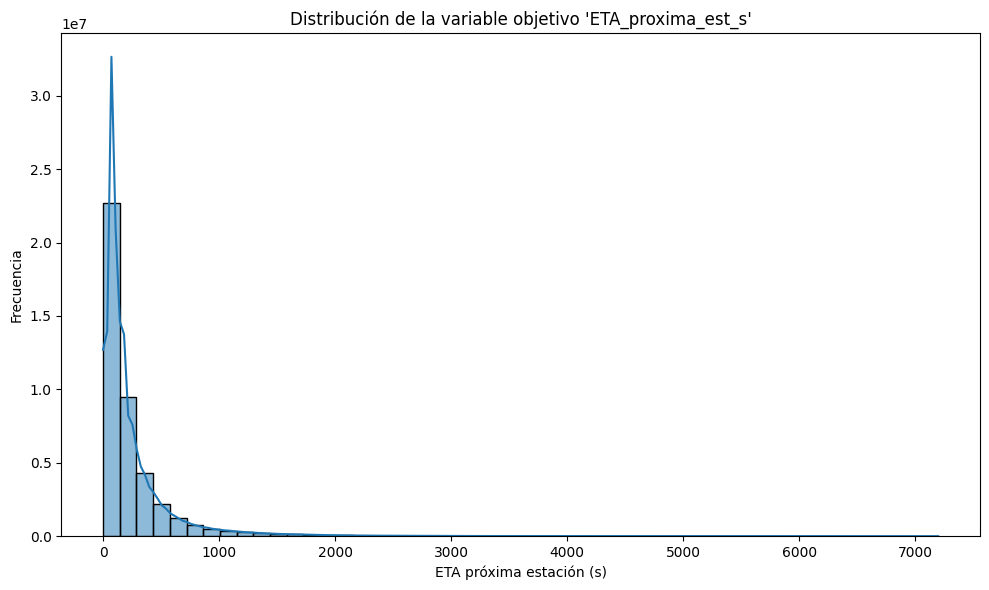

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribución de la variable objetivo 'ETA_proxima_est_s'
plt.figure(figsize=(10, 6))
sns.histplot(all_feature_engineered_df['ETA_proxima_est_s'].dropna(), bins=50, kde=True)
plt.title("Distribución de la variable objetivo 'ETA_proxima_est_s'")
plt.xlabel("ETA próxima estación (s)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [12]:
# Obtener la longitud de cada línea

import math
import numpy as np

def meters_per_degree(lat_deg):
    lat = math.radians(lat_deg)
    mlat = 111132.92 - 559.82*math.cos(2*lat) + 1.175*math.cos(4*lat) - 0.0023*math.cos(6*lat)
    mlon = 111412.84*math.cos(lat) - 93.5*math.cos(3*lat) + 0.118*math.cos(5*lat)
    return mlat, mlon

def ll_to_xy_m(lat, lon, lat0, lon0):
    mlat, mlon = meters_per_degree(lat0)
    return (lon - lon0)*mlon, (lat - lat0)*mlat

def cumulative_distances(x, y):
    dx = np.diff(x); dy = np.diff(y)
    return np.concatenate([[0.0], np.cumsum(np.sqrt(dx*dx + dy*dy))])

def load_line_polyline_csv(csv_path):
    df = pd.read_csv(csv_path)
    # Normaliza nombre de columnas
    needed = {"name","dir","lat","lon","station"}
    if not needed.issubset(df.columns):
        raise ValueError(f"Faltan columnas {needed - set(df.columns)} en {csv_path}")

    # Vértice es estación cuando "station" no es nula
    if "station" in df.columns:
        df["kind"] = np.where(df["station"].notna(), "station", "vertex")
    else:
        raise ValueError("Incluir 'station' para diferenciar estaciones.")

    if "kind" not in df.columns:
        df["kind"] = np.where(df["is_station"].astype(bool), "station", "vertex")

    # Utilizar el orden original del CSV
    df["order"] = np.arange(len(df), dtype=int)

    geoms = {}

    for (linea, d), g in df.sort_values("order").groupby(["name","dir"], sort=False):
        g = g.copy()

        latv = g["lat"].astype(float).to_numpy()
        lonv = g["lon"].astype(float).to_numpy()
        lat0, lon0 = float(latv.mean()), float(lonv.mean())

        rx, ry = ll_to_xy_m(latv, lonv, lat0, lon0)
        route_cum = cumulative_distances(rx, ry)
        
        # Ruta circular?
        is_circular = g["dir"].iloc[0] == 'CIRCULAR'

        route = dict(
            rx=rx, ry=ry, route_cum=route_cum,
            lat0=lat0, lon0=lon0,
            length_m=float(route_cum[-1]),
            is_circular=is_circular
        )
        
        geoms[(linea, d)] = route
        
    return geoms

In [ ]:
# Obtener la longitud de cada línea
LINES_DIR = Path("D:/2025/UVG/Tesis/repos/backend/data_preprocessing/complete_lines/")
line_lengths = {}
for line_file in LINES_DIR.glob("*.csv"):
    line_geoms = load_line_polyline_csv(line_file)
    for (linea, d), geom in line_geoms.items():
        line_lengths[(linea, d)] = geom['length_m']
        print(f"Longitud de la línea {linea}, dirección {d}: {geom['length_m']} m")
        
print(line_lengths)

# 

Longitud de la línea Linea_12, dirección VUELTA: 12200.808626648219 m
Longitud de la línea Linea_12, dirección IDA: 10845.387628085438 m
Longitud de la línea Linea_13-A, dirección VUELTA: 6012.190940444972 m
Longitud de la línea Linea_13-A, dirección IDA: 6534.035849736981 m
Longitud de la línea Linea_13-B, dirección VUELTA: 2254.6479853874207 m
Longitud de la línea Linea_13-B, dirección IDA: 2084.2982960687277 m
Longitud de la línea Linea_18-A, dirección IDA: 6404.3861825682725 m
Longitud de la línea Linea_18-A, dirección VUELTA: 4578.4823470769825 m
Longitud de la línea Linea_18-B, dirección IDA: 4945.409296311546 m
Longitud de la línea Linea_18-B, dirección VUELTA: 4729.713609387433 m
Longitud de la línea Linea_1, dirección CIRCULAR: 4614.474313630949 m
Longitud de la línea Linea_2, dirección VUELTA: 1037.4660760098993 m
Longitud de la línea Linea_2, dirección IDA: 2428.0171300075835 m
Longitud de la línea Linea_6, dirección IDA: 7776.4064575891425 m
Longitud de la línea Linea_6, di